## Movie Genre Prediction
### Isabella Oakes, Sarah Alqaysi, and Omar Elfeky
### https://github.com/isabellaoakes/Predicting-Movie-Genre

In [1]:
# Load packages
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')

import imdb
# import IMDbPY as imdb
import pandas as pd
import json
import nltk
import os
import re
import emoji
import spacy
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

from collections import Counter, defaultdict
from string import punctuation
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from yellowbrick.text import FreqDistVisualizer
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

from collections import Counter, defaultdict
from string import punctuation
from nltk.corpus import stopwords
sw = stopwords.words("english")
stop_words = sw

### Code for IMDb API

In [2]:
# Create IMDb Instance
ia = imdb.IMDb()

In [3]:
# Import movie names from list
#movienames = pd.read_csv(r'C:/UserData/z003cu8m/OneDrive - Siemens AG/Documents/Documents/Documents/Siemens/Computer Backup/Personal/MSADS/Text Mining/Week seven/movielist.csv')
movienames = pd.read_csv(r'C:/Users/LadyBug/Documents/GitHub/Predicting-Movie-Rating/movielist.csv')

movienames.head()

,Toy Story
0,Jumanji
1,Grumpier Old Men
2,Waiting to Exhale
3,Father of the Bride Part II
4,Heat


In [4]:
movienameslist = movienames.values.tolist()

In [5]:
# Pull information for movies from API
title = []
plot = []
genre = []

for name in movienameslist:
    #I added this because there was an error in at least one of the names.
    #Now only names with alphanumeric titles will be added
    if bool(re.match('^[a-zA-Z0-9]+$',str(name) )):
        movie = ia.search_movie(str(name))
        movie = movie[0]
        movie = ia.get_movie(movie.movieID)
        title.append(name)
        movieplot = movie.get('plot')
        plot.append(movieplot)
        moviegenre = movie.get('genre')
        genre.append('moviegenre')

In [6]:
# Combine into dataframe
moviedata = list(zip(title, plot, genre))

### Loading pre-pulled data

In [7]:
#movie_meta = pd.read_csv(r'C:/UserData/z003cu8m/OneDrive - Siemens AG/Documents/Documents/Documents/Siemens/Computer Backup/Personal/MSADS/Text Mining/Week seven/movies_metadata.csv')
#movie_meta = pd.read_csv(r'C:/Users/LadyBug/Documents/GitHub/Predicting-Movie-Rating/movies_data.csv')
movie_meta = pd.read_csv(r'C:/Users/LadyBug/Documents/GitHub/Predicting-Movie-Rating/movies_data.csv')

In [8]:
#movie_meta['genres'] = movie_meta['genres'].apply(lambda x: [i['name'] for i in eval(x)])
#movie_meta['genres'] = movie_meta['genres'].apply(lambda x: ' '.join([i.replace(" ", "") for i in x]))
#movie_meta['genres']

### Data Exploration and Pre-processing

In [9]:
# extracting titles, genres and movie overview

movie_meta_new = movie_meta[["title", "genres", "overview"]]

#This is the first step to be able to convert the json. We need to replace single quotes with double quotes.
movie_meta_new = movie_meta_new.replace("'",'"', regex=True)

#Previously I had this as the first step but there is a warning/potential bug if we do it this way. I'm leaving it as a warning, lol.
#movie_meta_new['genres'] = movie_meta_new['genres'].str.replace("'",'"')


nice_genres =[]
unique_genres =[]
for row in movie_meta_new['genres']:
    #Now that the genres has quotes it can be converted from a string to a json dictionary
    dict_row = json.loads(row)
    #After being converted to a json dictionary we can use a json pandas parser to make it into a dataframe
    df_row = pd.json_normalize(dict_row)
    #Some of the json fields are empty inside which causes an error once we finish all the parsings and try to add it to the list 
    if not df_row.empty:
        list_row = df_row["name"].to_list()
        unique_genres.append( list_row[0])
        nice_genres.append( list_row)
    #We have to add a null to the list where the json field is empty so we don't mess with the structure of the dataframe
    else:
        nice_genres.append(float("NaN"))
        unique_genres.append( float("NaN"))

movie_meta_new["unique_genres"]=unique_genres
movie_meta_new["nice_genres"]=nice_genres

In [10]:
#Remove low count genres
# Get the count of each value
value_counts = movie_meta_new['nice_genres'].value_counts()

# Select the values where the count is less than 2 
to_remove = value_counts[value_counts < 2].index

# Keep rows where the city column is not in to_remove
movie_meta_new = movie_meta_new[~movie_meta_new.nice_genres.isin(to_remove)]

# movie_meta_new.drop(movie_meta_new.loc[movie_meta_new['nice_genres']== 'Odyssey Media'].index, inplace=True)
#Now we can drop those empty fields which we converted into nulls.
movie_meta_new = movie_meta_new.dropna()
#movie_meta_new.loc[movie_meta_new['unique_genres'] == 'NaN']
movie_meta_new


,title,genres,overview,unique_genres,nice_genres
0,Toy Story,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 35, ""name"": ""Comedy""}, {""id"": 10751, ""name"": ""Family""}]","Led by Woody, Andy""s toys live happily in his room until Andy""s birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy""s heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their diffe...",Animation,"[Animation, Comedy, Family]"
1,Jumanji,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 10751, ""name"": ""Family""}]","When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who""s been trapped inside the game for 26 years -- into their living room. Alan""s only hope for freedom is to finish the game, which proves risky as all ...",Adventure,"[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[{""id"": 10749, ""name"": ""Romance""}, {""id"": 35, ""name"": ""Comedy""}]","A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she""ll scare the fish away. But she""s less interested in seafood than she is in ...",Romance,"[Romance, Comedy]"
3,Waiting to Exhale,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""name"": ""Romance""}]","Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.",Comedy,"[Comedy, Drama, Romance]"
4,Father of the Bride Part II,"[{""id"": 35, ""name"": ""Comedy""}]","Just when George Banks has recovered from his daughter""s wedding, he receives the news that she""s pregnant ... and that George""s wife, Nina, is expecting too. He was planning on selling their home, but that""s a plan that -- like George -- will have to change with the arrival of both a grandchild...",Comedy,[Comedy]
...,...,...,...,...,...
45459,Caged Heat 3000,"[{""id"": 878, ""name"": ""Science Fiction""}]","It""s the year 3000 AD. The world""s most dangerous women are banished to a remote asteroid 45 million light years from earth. Kira Murphy doesn""t belong; wrongfully accused of a crime she did not commit, she""s thrown in this interplanetary prison and left to her own defenses. But Kira""s a fighter...",Science Fiction,[Science Fiction]
45460,Robin Hood,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name"": ""Action""}, {""id"": 10749, ""name"": ""Romance""}]","Yet another version of the classic epic, with enough variation to make it interesting. The story is the same, but some of the characters are quite different from the usual, in particular Uma Thurman""s very special maid Marian. The photography is also great, giving the story a somewhat darker tone.",Drama,"[Drama, Action, Romance]"
45461,Subdue,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10751, ""name"": ""Family""}]",Rising and falling between a man and woman.,Drama,"[Drama, Family]"
45462,Century of Birthing,"[{""id"": 18, ""name"": ""Drama""}]",An artist struggles to finish his work while a storyline about a cult plays in his head.,Drama,[Drama]


In [11]:
# Removing secondary genres
movie_meta_new["singlegenre"] = movie_meta_new["unique_genres"]

movie_meta_new["singlegenre"]

0              Animation
1              Adventure
2                Romance
3                 Comedy
4                 Comedy
              ...       
45459    Science Fiction
45460              Drama
45461              Drama
45462              Drama
45463             Action
Name: singlegenre, Length: 39979, dtype: object

In [12]:
movie_meta_new.unique_genres.unique()

array(['Animation', 'Adventure', 'Romance', 'Comedy', 'Action', 'Family',
       'History', 'Drama', 'Crime', 'Fantasy', 'Thriller', 'Horror',
       'Documentary', 'Music', 'Mystery', 'Science Fiction', 'Western',
       'War', 'TV Movie', 'Foreign'], dtype=object)

### Genre Cleaning

In [13]:
# Combining categories and dropping some to limit the number of genres to 8
movie_meta_new['singlegenre'] = movie_meta_new['singlegenre'].replace({
    'Drama' : 'Drama/Mystery',
    'Action' : 'Action/Adventure',
    'Adventure' : 'Action/Adventure',
    'Mystery' : 'Drama/Mystery',
    'War' : 'Documentary/History/War',
    'Documentary' : 'Documentary/History/War',
    'History' : 'Documentary/History/War',
    'Horror' : 'Horror/Crime/Thriller',
    'Crime' : 'Horror/Crime/Thriller',
    'Thriller' : 'Horror/Crime/Thriller',
    'Animation' : 'Animation/Family',
    'Family' : 'Animation/Family',
    'Science Fiction' : 'Science Fiction/Fantasy',
    'Fantasy' : 'Science Fiction/Fantasy'   
})

movie_meta_new = movie_meta_new[~movie_meta_new['singlegenre'].isin(['Music', 'Western', 'TV Movie', 'Foreign', 'Carousel Productions', 'Aniplex'])]

### Data Cleaning and Tokenization

In [14]:
# Data cleaning

# Some punctuation variations
punctuation = set(punctuation) 
# stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
 
def remove_punctuation(text, punct_set= punctuation) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    
    return( re.split('\s+', text) )

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


<>:16: DeprecationWarning: invalid escape sequence \s
<>:16: DeprecationWarning: invalid escape sequence \s
<ipython-input-14-6c3b1104caab>:16: DeprecationWarning: invalid escape sequence \s
  return( re.split('\s+', text) )


In [15]:
# apply the `pipeline` technique 

my_pipeline_overview = [str.lower, remove_punctuation, remove_stopwords]
my_pipeline_tokenized = [str.lower, remove_punctuation, remove_stopwords,tokenize]

movie_meta_new["overview"] = movie_meta_new["overview"].apply(prepare,pipeline=my_pipeline_overview)
movie_meta_new["tokenized"] = movie_meta_new["overview"].apply(prepare,pipeline=my_pipeline_tokenized)
movie_meta_new.head() 

,title,genres,overview,unique_genres,nice_genres,singlegenre,tokenized
0,Toy Story,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 35, ""name"": ""Comedy""}, {""id"": 10751, ""name"": ""Family""}]",led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences,Animation,"[Animation, Comedy, Family]",Animation/Family,"[led, woody, andys, toys, live, happily, room, andys, birthday, brings, buzz, lightyear, onto, scene, afraid, losing, place, andys, heart, woody, plots, buzz, circumstances, separate, buzz, woody, owner, duo, eventually, learns, put, aside, differences]"
1,Jumanji,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 10751, ""name"": ""Family""}]",siblings judy peter discover enchanted board game opens door magical world unwittingly invite alan adult whos trapped inside game 26 years living room alans hope freedom finish game proves risky three find running giant rhinoceroses evil monkeys terrifying creatures,Adventure,"[Adventure, Fantasy, Family]",Action/Adventure,"[siblings, judy, peter, discover, enchanted, board, game, opens, door, magical, world, unwittingly, invite, alan, adult, whos, trapped, inside, game, 26, years, living, room, alans, hope, freedom, finish, game, proves, risky, three, find, running, giant, rhinoceroses, evil, monkeys, terrifying, ..."
2,Grumpier Old Men,"[{""id"": 10749, ""name"": ""Romance""}, {""id"": 35, ""name"": ""Comedy""}]",family wedding reignites ancient feud nextdoor neighbors fishing buddies john max meanwhile sultry italian divorcée opens restaurant local bait shop alarming locals worry shell scare fish away shes less interested seafood cooking hot time max,Romance,"[Romance, Comedy]",Romance,"[family, wedding, reignites, ancient, feud, nextdoor, neighbors, fishing, buddies, john, max, meanwhile, sultry, italian, divorcée, opens, restaurant, local, bait, shop, alarming, locals, worry, shell, scare, fish, away, shes, less, interested, seafood, cooking, hot, time, max]"
3,Waiting to Exhale,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""name"": ""Romance""}]",cheated mistreated stepped women holding breath waiting elusive good man break string lessthanstellar lovers friends confidants vannah bernie glo robin talk determined find better way breathe,Comedy,"[Comedy, Drama, Romance]",Comedy,"[cheated, mistreated, stepped, women, holding, breath, waiting, elusive, good, man, break, string, lessthanstellar, lovers, friends, confidants, vannah, bernie, glo, robin, talk, determined, find, better, way, breathe]"
4,Father of the Bride Part II,"[{""id"": 35, ""name"": ""Comedy""}]",george banks recovered daughters wedding receives news shes pregnant georges wife nina expecting planning selling home thats plan like george change arrival grandchild kid,Comedy,[Comedy],Comedy,"[george, banks, recovered, daughters, wedding, receives, news, shes, pregnant, georges, wife, nina, expecting, planning, selling, home, thats, plan, like, george, change, arrival, grandchild, kid]"


### Running Descriptive Statistics

In [16]:
# Code for Descriptive Statistics

def descriptive_stats(tokens, num_tokens = 5, verbose=True) :

    # Fill in the correct values here. 
    num_characters = len(tokens) - tokens.count(" ")
    paragraph = re.sub(r'[^\w\s]', '', tokens)
    words = paragraph.split()
    num_tokens = len(words)
    uniquewords = Counter(words)
    num_unique_tokens = len(uniquewords)
    lexical_diversity = num_unique_tokens/num_tokens
    uniquewordlist = uniquewords.most_common(5)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
    # print the five most common tokens
        print(f"The five most common tokens are:")
        print(uniquewordlist)
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [17]:
# Arrange tokens in a list for descriptive statistics
movieplotnew = []
movieplot = movie_meta_new['overview'].values.tolist()
for item in movieplot:
    plot = item
    newplot = str.split(plot)
    movieplotnew.append(newplot)

In [18]:
# Generate descriptive statistics
print('The descriptive statistics for the movie plots are:')
descriptive_stats(str(movieplotnew), verbose=True)

The descriptive statistics for the movie plots are:
There are 1219282 tokens in the data.
There are 84043 unique tokens in the data.
There are 11328840 characters in the data.
The lexical diversity is 0.069 in the data.
The five most common tokens are:
[('life', 6615), ('one', 6273), ('young', 5660), ('new', 4927), ('film', 4794)]


[1219282, 84043, 0.06892827090041516, 11328840]

In [19]:
movie_meta_new.drop(['genres'], axis=1, inplace=True)
#movie_meta_new.columns

In [20]:
movie_meta_new['singlegenre']

0               Animation/Family
1               Action/Adventure
2                        Romance
3                         Comedy
4                         Comedy
                  ...           
45459    Science Fiction/Fantasy
45460              Drama/Mystery
45461              Drama/Mystery
45462              Drama/Mystery
45463           Action/Adventure
Name: singlegenre, Length: 38774, dtype: object

### Visualizing the genre frequency:

,title,overview,unique_genres,nice_genres,singlegenre,tokenized
45459,Caged Heat 3000,year 3000 ad worlds dangerous women banished remote asteroid 45 million light years earth kira murphy doesnt belong wrongfully accused crime commit shes thrown interplanetary prison left defenses kiras fighter soon finds middle female gang war everyone wants piece action piece caged heat 3000 ta...,Science Fiction,[Science Fiction],Science Fiction/Fantasy,"[year, 3000, ad, worlds, dangerous, women, banished, remote, asteroid, 45, million, light, years, earth, kira, murphy, doesnt, belong, wrongfully, accused, crime, commit, shes, thrown, interplanetary, prison, left, defenses, kiras, fighter, soon, finds, middle, female, gang, war, everyone, wants..."
45460,Robin Hood,yet another version classic epic enough variation make interesting story characters quite different usual particular uma thurmans special maid marian photography also great giving story somewhat darker tone,Drama,"[Drama, Action, Romance]",Drama/Mystery,"[yet, another, version, classic, epic, enough, variation, make, interesting, story, characters, quite, different, usual, particular, uma, thurmans, special, maid, marian, photography, also, great, giving, story, somewhat, darker, tone]"
45461,Subdue,rising falling man woman,Drama,"[Drama, Family]",Drama/Mystery,"[rising, falling, man, woman]"
45462,Century of Birthing,artist struggles finish work storyline cult plays head,Drama,[Drama],Drama/Mystery,"[artist, struggles, finish, work, storyline, cult, plays, head]"
45463,Betrayal,one hits goes wrong professional assassin ends suitcase full million dollars belonging mob boss,Action,"[Action, Drama, Thriller]",Action/Adventure,"[one, hits, goes, wrong, professional, assassin, ends, suitcase, full, million, dollars, belonging, mob, boss]"


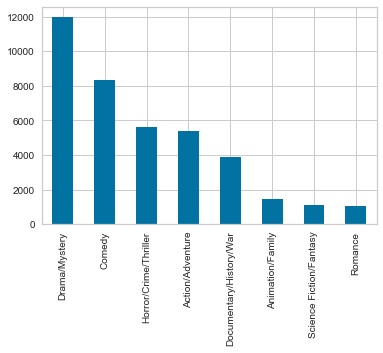

In [21]:

movie_meta_new['singlegenre'].value_counts().plot.bar()
movie_meta_new.tail()


### Visualizing the words and their frequency in the "overview/plot" column:

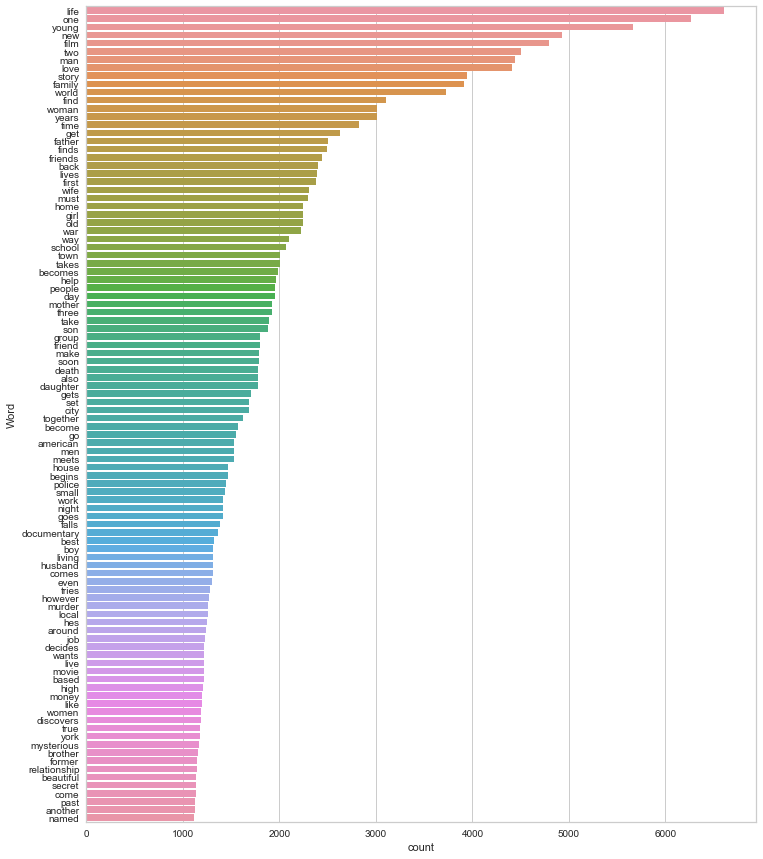

In [22]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
    
  # print 100 most frequent words 
freq_words(movie_meta_new['overview'], 100)

In [23]:
# movie_meta_new["singlegenre"] = movie_meta_new["singlegenre"].dropna().tail()
# Filling NA valuse with "No genres"
movie_meta_new["singlegenre"].fillna("No genres", inplace = True)
movie_meta_new["nice_genres"].fillna("No genres", inplace = True)

In [24]:
movie_meta_new.head()

,title,overview,unique_genres,nice_genres,singlegenre,tokenized
0,Toy Story,led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences,Animation,"[Animation, Comedy, Family]",Animation/Family,"[led, woody, andys, toys, live, happily, room, andys, birthday, brings, buzz, lightyear, onto, scene, afraid, losing, place, andys, heart, woody, plots, buzz, circumstances, separate, buzz, woody, owner, duo, eventually, learns, put, aside, differences]"
1,Jumanji,siblings judy peter discover enchanted board game opens door magical world unwittingly invite alan adult whos trapped inside game 26 years living room alans hope freedom finish game proves risky three find running giant rhinoceroses evil monkeys terrifying creatures,Adventure,"[Adventure, Fantasy, Family]",Action/Adventure,"[siblings, judy, peter, discover, enchanted, board, game, opens, door, magical, world, unwittingly, invite, alan, adult, whos, trapped, inside, game, 26, years, living, room, alans, hope, freedom, finish, game, proves, risky, three, find, running, giant, rhinoceroses, evil, monkeys, terrifying, ..."
2,Grumpier Old Men,family wedding reignites ancient feud nextdoor neighbors fishing buddies john max meanwhile sultry italian divorcée opens restaurant local bait shop alarming locals worry shell scare fish away shes less interested seafood cooking hot time max,Romance,"[Romance, Comedy]",Romance,"[family, wedding, reignites, ancient, feud, nextdoor, neighbors, fishing, buddies, john, max, meanwhile, sultry, italian, divorcée, opens, restaurant, local, bait, shop, alarming, locals, worry, shell, scare, fish, away, shes, less, interested, seafood, cooking, hot, time, max]"
3,Waiting to Exhale,cheated mistreated stepped women holding breath waiting elusive good man break string lessthanstellar lovers friends confidants vannah bernie glo robin talk determined find better way breathe,Comedy,"[Comedy, Drama, Romance]",Comedy,"[cheated, mistreated, stepped, women, holding, breath, waiting, elusive, good, man, break, string, lessthanstellar, lovers, friends, confidants, vannah, bernie, glo, robin, talk, determined, find, better, way, breathe]"
4,Father of the Bride Part II,george banks recovered daughters wedding receives news shes pregnant georges wife nina expecting planning selling home thats plan like george change arrival grandchild kid,Comedy,[Comedy],Comedy,"[george, banks, recovered, daughters, wedding, receives, news, shes, pregnant, georges, wife, nina, expecting, planning, selling, home, thats, plan, like, george, change, arrival, grandchild, kid]"


### Text to Features Conversion

In [25]:
# multi class conversion on the "nice_genres" column

# converting text to feature

from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movie_meta_new["nice_genres"])

# transform target variable
y =  multilabel_binarizer.transform(movie_meta_new["nice_genres"])


In [26]:
# single class conversion on the "singlegenre" column 

#vectorizer = CountVectorizer()

# tokenize and build vocab
#vectorizer.fit(movie_meta_new["singlegenre"])

# encode document
#y = vectorizer.transform(movie_meta_new["singlegenre"])

In [58]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

# spliting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(movie_meta_new['overview'], y, test_size=0.2, random_state=9)

# creating TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Building the Prediction Model

In [48]:
# Creating Logistic Regression Model
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
# fiting the model on the training data
clf.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [49]:
# making predictions for the test set
y_pred = clf.predict(X_test_tfidf)
# y_pred
multilabel_binarizer.inverse_transform(y_pred)[3]
# evaluate performance
f1_score(y_test, y_pred, average="micro")

0.48579545454545453

We can see the F1-Score for Logistic Regression is about 48%.

In [50]:
# predict probabilities
y_pred_prob = clf.predict_proba(X_test_tfidf)
# changing the threshold value from 0.5 to 0.21 to improve f1 score and overall model performance
t = 0.21 
y_pred_new = (y_pred_prob >= t).astype(int)
# re-evaluate performance
f1_score(y_test, y_pred_new, average="micro")

0.5899470173223158

We can see that changing the threshold value improved the model performance to ~ 59%

In [35]:
# Generating multi-class prediction model
def infer_tags(q):
    #Tokenize isn't needed here
    #q = tokenize(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [36]:
for i in range(5): 
    k = X_test.sample(1).index[0] 
    #print("Movie: ", movie_meta_new['title'][k], "\nPredicted genre: ", infer_tags(X_test[k])), print("Actual genre: ", movie_meta_new['singlegenre'][k], "\n")
    print("Movie: ", movie_meta_new['title'][k], "\nPredicted genre: ", infer_tags(X_test[k])), print("Actual genre: ", movie_meta_new['nice_genres'][k], "\n")

Movie:  Kill Bill: Vol. 2 
Predicted genre:  [('Horror', 'Thriller')]
Actual genre:  ['Action', 'Crime', 'Thriller'] 

Movie:  Secrets of the Tribe 
Predicted genre:  [()]
Actual genre:  ['Documentary', 'TV Movie'] 

Movie:  Soldier of God 
Predicted genre:  [('Drama',)]
Actual genre:  ['Drama', 'History'] 

Movie:  Alice in Wonderland 
Predicted genre:  [('Comedy',)]
Actual genre:  ['Family', 'Fantasy', 'Science Fiction'] 

Movie:  High Security Vacation 
Predicted genre:  [('Drama',)]
Actual genre:  ['Comedy', 'Action'] 



In [37]:
# Creating Naive Bayes Model
def infer_tags2(q):
    return clf.predict(count_vect.transform(q))

#X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
# spliting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(movie_meta_new['overview'], movie_meta_new['singlegenre'], test_size=0.2, random_state=9)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)
for i in range(5): 
    k = X_test.sample(1)
    #print("Movie: ", movie_meta_new['title'][k], "\nPredicted genre: ", infer_tags(X_test[k])), print("Actual genre: ", movie_meta_new['singlegenre'][k], "\n")
    print( "\nMovie: ", movie_meta_new['title'][k.index[0]], "\nPredicted genre: ", clf.predict(count_vect.transform(k)))
    print("Actual genre: ", movie_meta_new['singlegenre'][k.index[0]], "\n")

# making predictions for the test set
y_pred = clf.predict(count_vect.transform(X_test)) 




Movie:  Thieves 
Predicted genre:  ['Drama/Mystery']
Actual genre:  Romance 


Movie:  Shadow of the Thin Man 
Predicted genre:  ['Drama/Mystery']
Actual genre:  Comedy 


Movie:  Confess 
Predicted genre:  ['Drama/Mystery']
Actual genre:  Action/Adventure 


Movie:  The Redwood Massacre 
Predicted genre:  ['Horror/Crime/Thriller']
Actual genre:  Science Fiction/Fantasy 


Movie:  The Married Woman 
Predicted genre:  ['Drama/Mystery']
Actual genre:  Drama/Mystery 



In [38]:
# evaluate performance
print(f1_score(y_test, y_pred, average="micro"))

0.4167633784655062


The F1-Score With Naive Bayes is less than the logistic regression model and many of the predictions seem to be for the genre with the largest count.

In [39]:
# Example of tokenized data
movie_meta_new['overview'][0],movie_meta_new['tokenized'][0][:7],

('led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences',
 ['led', 'woody', 'andys', 'toys', 'live', 'happily', 'room'])

In [40]:
# List of genres
movie_meta_new.singlegenre.unique()

array(['Animation/Family', 'Action/Adventure', 'Romance', 'Comedy',
       'Documentary/History/War', 'Drama/Mystery',
       'Horror/Crime/Thriller', 'Science Fiction/Fantasy'], dtype=object)

In [53]:
#Removing most common words from data 
words = ['one', 'two', 'life', 'woman', 'man']
removewords = '|'.join(words)
movie_meta_new['worddrop'] = movie_meta_new['overview'].str.replace(removewords, '')

In [54]:
X_train, X_test, y_train, y_test = train_test_split(movie_meta_new['worddrop'], y, test_size=0.2, random_state=9)

# creating TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [55]:
# Creating Logistic Regression Model
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
# fiting the model on the training data
clf.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [56]:
# predict probabilities
y_pred_prob = clf.predict_proba(X_test_tfidf)
# changing the threshold value from 0.5 to 0.21 to improve f1 score and overall model performance
t = 0.21 
y_pred_new = (y_pred_prob >= t).astype(int)
# re-evaluate performance
f1_score(y_test, y_pred_new, average="micro")

0.5893754289636239

Removing words doesn't improve the model accuracy.

### Creating a Topic Model

In [65]:
categories = ['Animation/Family', 'Action/Adventure', 'Romance', 'Comedy',
       'Science Fiction/Fantasy', 'Documentary/History/War',
       'Drama/Mystery', 'Horror/Crime/Thriller']
# BTAP repo function
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

count_text_vectorizer = CountVectorizer(stop_words=sw, min_df=9, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(movie_meta_new['overview'])
# count_text_vectors.shape


tfidf_text_vectorizer = TfidfVectorizer(stop_words=sw, min_df=9, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(movie_meta_new['overview'])
# tfidf_text_vectors.shape

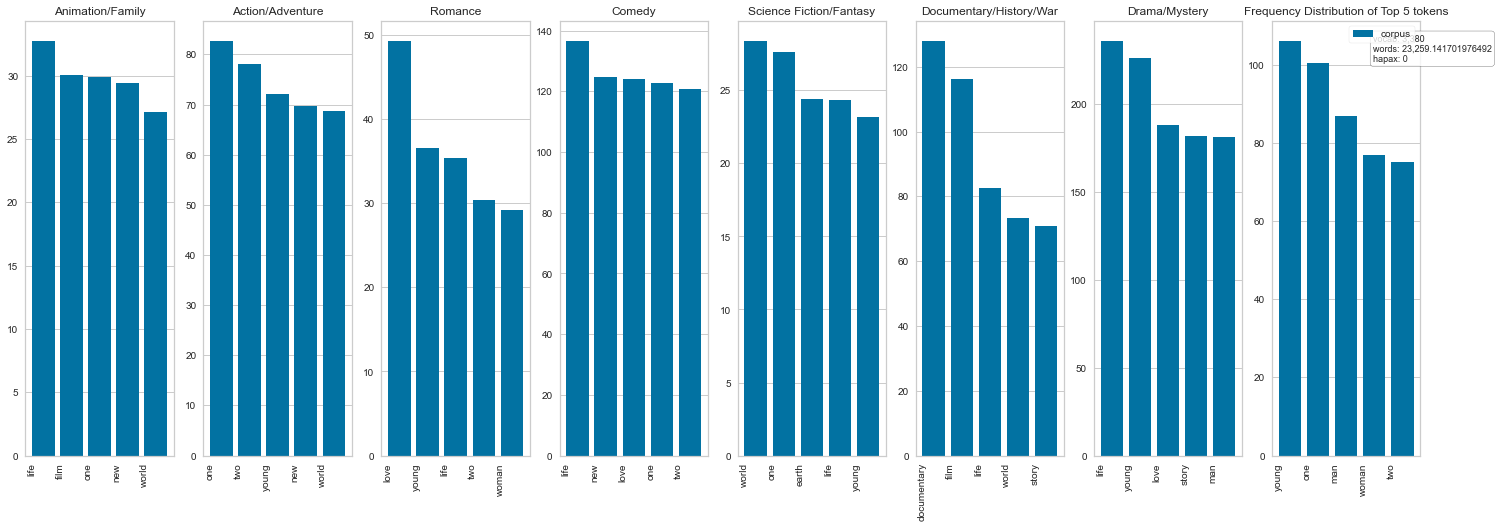

<AxesSubplot:title={'center':'Frequency Distribution of Top 5 tokens'}>

In [66]:
# Looking at top words for each topic
fig, axs = plt.subplots(1, 8,figsize=(25,8))
# Load the text data
for i in range (0,8):
    corpus = movie_meta_new.loc[ movie_meta_new['singlegenre'] == categories[i], 'overview']
    #print("Top words for category:" + categories[i])
    axs[i].set_title(categories[i])
    #axs[i].legend().set_visible(False)
    #axs[i].get_legend().set_visible(False)
    #axs[i].legend().legendPatch.set_visible(False)
    tfidf_text_vectorizer2 =  TfidfVectorizer(stop_words=sw, min_df=8, max_df=0.7)
    docs = tfidf_text_vectorizer2.fit_transform(corpus) #CountVectorizer()
    features   = tfidf_text_vectorizer2.get_feature_names()

    visualizer = FreqDistVisualizer(ax = axs[i],features=features, orient='v', n = 5)
    visualizer.fit(docs)
visualizer.show()

In [67]:
# Running topics without top words to see if they are have more variability
count_text_vectorizer = CountVectorizer(stop_words=sw, min_df=9, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(movie_meta_new['worddrop'])



tfidf_text_vectorizer = TfidfVectorizer(stop_words=sw, min_df=9, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(movie_meta_new['worddrop'])


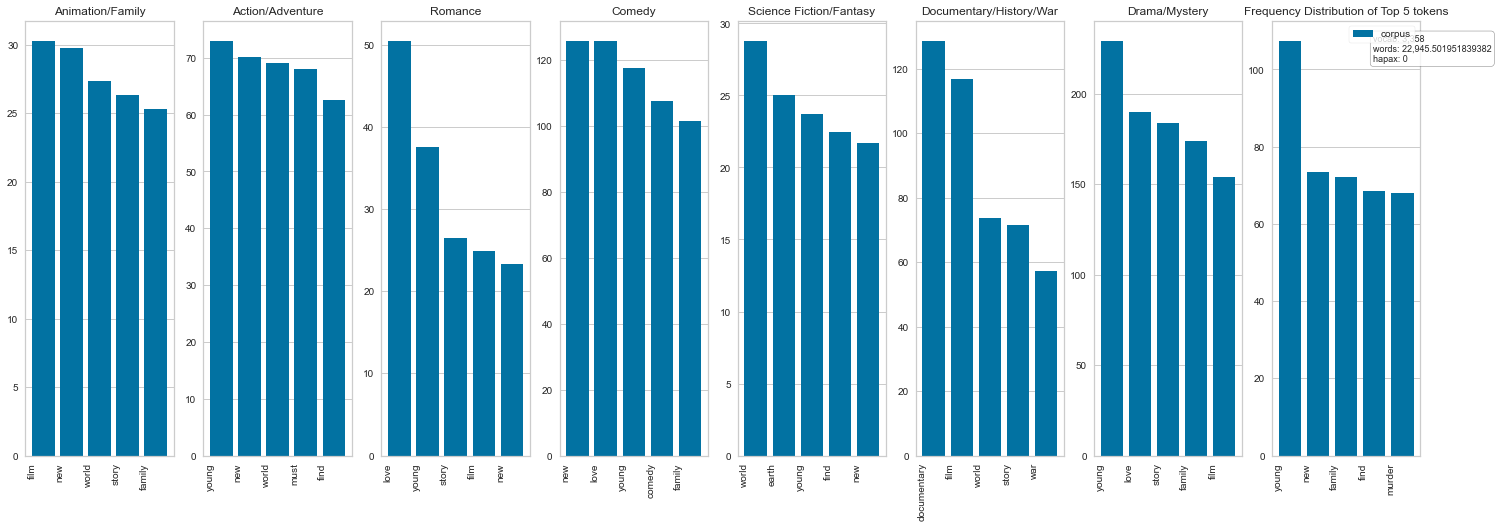

<AxesSubplot:title={'center':'Frequency Distribution of Top 5 tokens'}>

In [68]:
# Looking at top words for each topic
fig, axs = plt.subplots(1, 8,figsize=(25,8))
# Load the text data
for i in range (0,8):
    corpus = movie_meta_new.loc[ movie_meta_new['singlegenre'] == categories[i], 'worddrop']
    #print("Top words for category:" + categories[i])
    axs[i].set_title(categories[i])
    #axs[i].legend().set_visible(False)
    #axs[i].get_legend().set_visible(False)
    #axs[i].legend().legendPatch.set_visible(False)
    tfidf_text_vectorizer2 =  TfidfVectorizer(stop_words=sw, min_df=8, max_df=0.7)
    docs = tfidf_text_vectorizer2.fit_transform(corpus) #CountVectorizer()
    features   = tfidf_text_vectorizer2.get_feature_names()

    visualizer = FreqDistVisualizer(ax = axs[i],features=features, orient='v', n = 5)
    visualizer.fit(docs)
visualizer.show()

Topics are slightly better, but still have overlap.

In [69]:
# Creating and LDA model
lda_text_model = LatentDirichletAllocation( n_components = 8, random_state = 42)
W_lda_matrix = lda_text_model.fit_transform( count_text_vectors)
H_lda_matrix = lda_text_model.components_
display_topics(lda_text_model, count_text_vectorizer.get_feature_names())


Topic 00
  love (0.88)
  get (0.77)
  young (0.57)
  back (0.51)
  friends (0.49)

Topic 01
  police (0.83)
  young (0.74)
  wife (0.65)
  new (0.61)
  murder (0.58)

Topic 02
  world (0.87)
  war (0.87)
  must (0.58)
  group (0.55)
  evil (0.42)

Topic 03
  film (2.06)
  new (1.07)
  documentary (0.93)
  story (0.61)
  first (0.58)

Topic 04
  story (1.80)
  film (1.58)
  based (0.88)
  town (0.77)
  small (0.65)

Topic 05
  family (1.59)
  love (1.33)
  young (1.04)
  father (0.86)
  mother (0.83)

Topic 06
  school (1.29)
  high (0.73)
  new (0.70)
  young (0.60)
  world (0.48)

Topic 07
  dr (0.62)
  story (0.49)
  young (0.45)
  time (0.41)
  people (0.38)


In [70]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [71]:
pyLDAvis.display(lda_display)

### Next Steps

To further improve the model, additional words may be removed to allow topics to have more variability. Genres may also be adjusted as there are some subcategories such as 'romcoms' which are very popular and so romance could be split between 'drama' and 'comedy' for different and possibly more accurate genres. Trying more and less genres may also help improve model performance. Overall, an exploration of genre may improve genres and create subgenres that may appeal to more people. 